## 1. EURUSD-Labels laden

In diesem Abschnitt lade ich die bereits berechneten EURUSD-Labels aus  
`data/processed/fx/eurusd_labels.csv`.

- Die Datei enthält für jeden Tag:
  - `Date`: Datum
  - `Close`, `High`, `Low`, `Open`, `Volume`
  - `lookahead_return`: Rendite über 4 Tage (t → t+4)
  - `label`: Klassifikation (`up`, `down`, `neutral`) mit strenger Monotonie-Bedingung

Da wir die News-Daten erst ab 2020 haben, filtere ich die Labels hier ebenfalls ab 2020.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Optional: etwas schönere Standard-Optik
plt.style.use("seaborn-v0_8")

# EURUSD-Labels laden (inkl. lookahead_return und label)
# Pfad relativ vom Notebook-Ordner (notebooks/) aus
labels = pd.read_csv(
    "../data/processed/fx/eurusd_labels.csv",
    parse_dates=["Date"]
)

# Ab 2020 filtern, weil es ab da News-Features gibt
labels_2020 = labels[labels["Date"] >= "2020-01-01"].copy()

labels_2020.head()


,Date,Close,High,Low,Open,Volume,lookahead_return,label
1301,2020-01-01,1.122083,1.122838,1.115947,1.122083,0,-0.002035,neutral
1302,2020-01-02,1.122083,1.122712,1.116682,1.121894,0,-0.005890,down
1303,2020-01-03,1.117144,1.118068,1.112570,1.117081,0,-0.005212,down
1304,2020-01-06,1.116196,1.120825,1.115810,1.116246,0,-0.004556,neutral
1305,2020-01-07,1.119799,1.119946,1.113487,1.119583,0,-0.007263,down


## 2. Kursverlauf und 4-Tage-Rendite visualisieren

Hier plotte ich zwei Größen gleichzeitig:

1. **EURUSD-Schlusskurs** auf der linken Y-Achse  
2. **4-Tage-Lookahead-Rendite** (`lookahead_return`) auf der rechten Y-Achse

Zusätzlich zeichne ich die Schwellen von **+1 %** und **−1 %** ein.
Diese Schwellen werden aktuell für das Labeling verwendet:

- `up`, wenn Rendite ≥ +1 % und der Kurs 4 Tage in Folge streng steigt
- `down`, wenn Rendite ≤ −1 % und der Kurs 4 Tage in Folge streng fällt
- sonst `neutral`

Die Grafik hilft mir zu verstehen, wann der Kurs wirklich „trendartig“ steigt oder fällt.


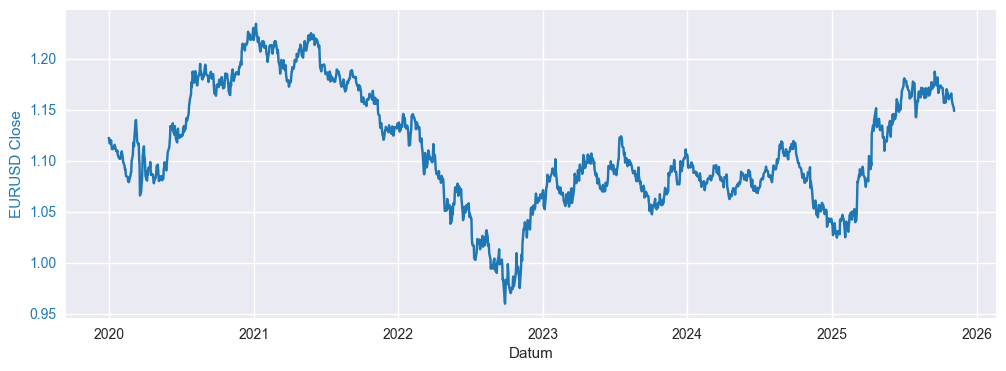

In [2]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# 1. Achse: EURUSD-Schlusskurs
ax1.plot(labels_2020["Date"], labels_2020["Close"],
         color="tab:blue", label="Close")
ax1.set_xlabel("Datum")
ax1.set_ylabel("EURUSD Close", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# # 2. Achse: Lookahead-Return über 4 Tage
# ax2 = ax1.twinx()
# ax2.plot(labels_2020["Date"], labels_2020["lookahead_return"],
# color="tab:orange", label="4-Tage-Return")
# ax2.axhline(0.01, color="green", linestyle="--", alpha=0.5, label="+1% Schwelle")
# ax2.axhline(-0.01, color="red", linestyle="--", alpha=0.5, label="-1% Schwelle")
# ax2.set_ylabel("Lookahead-Return (4 Tage)", color="tab:orange")
# ax2.tick_params(axis="y", labelcolor="tab:orange")

# # Gemeinsame Legende
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# plt.title("EURUSD ab 2020 – Kurs & 4-Tage-Return")
# plt.tight_layout()
# plt.show()


## 3. Up/Down-Tage im Kursverlauf hervorheben

In dieser Grafik markiere ich die Tage mit den Labels:

- **grün**: `up`
- **rot**: `down`
- **grau**: `neutral`

Die Kurslinie (hellgrau) zeigt den gesamten Verlauf, die farbigen Punkte markieren die Tage,
an denen nach unserer strengen 4-Tage-Logik ein klares `up` oder `down` erkannt wurde.
So kann ich visuell prüfen, ob das Labeling zu meinem Intuition passt:
„direkte“ Aufwärts- oder Abwärtsbewegungen über 4 Tage ohne Richtungswechsel.


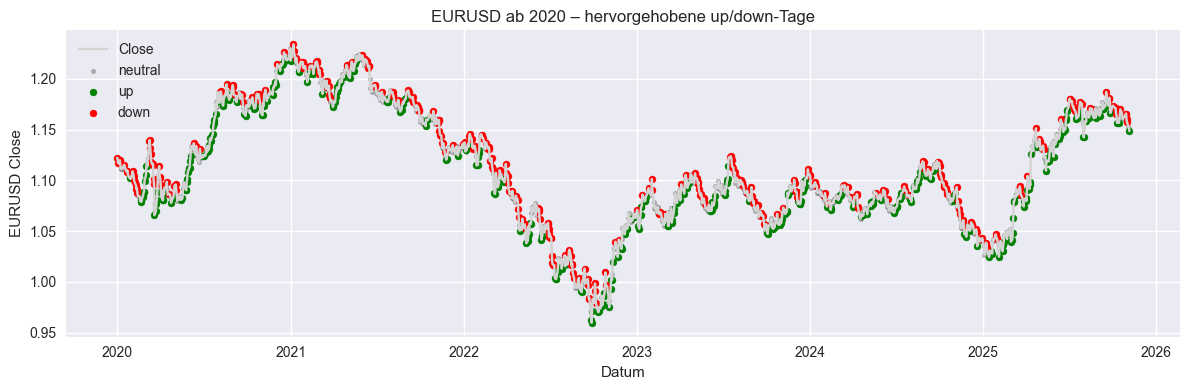

In [3]:
mask_up = labels_2020["label"] == "up"
mask_down = labels_2020["label"] == "down"
mask_neutral = labels_2020["label"] == "neutral"

fig, ax = plt.subplots(figsize=(12, 4))

# Kurslinie
ax.plot(labels_2020["Date"], labels_2020["Close"],
        color="lightgray", label="Close")

# Punkte für neutral / up / down
ax.scatter(labels_2020.loc[mask_neutral, "Date"],
           labels_2020.loc[mask_neutral, "Close"],
           color="gray", s=10, alpha=0.6, label="neutral")

ax.scatter(labels_2020.loc[mask_up, "Date"],
           labels_2020.loc[mask_up, "Close"],
           color="green", s=25, label="up")

ax.scatter(labels_2020.loc[mask_down, "Date"],
           labels_2020.loc[mask_down, "Close"],
           color="red", s=25, label="down")

ax.set_xlabel("Datum")
ax.set_ylabel("EURUSD Close")
ax.set_title("EURUSD ab 2020 – hervorgehobene up/down-Tage")
ax.legend()
plt.tight_layout()
plt.show()


## Pfad-Visualisierung auf Zeitachse (Horizon = Index-Schritte)

In dieser Visualisierung möchte ich für `up`- oder `down`-Labels sehen,
wie sich der Kurs **zwischen Starttag und Horizonttag** verhält.

Wichtig:

- Im Label-Code (`label_eurusd`) wird der Horizont mit  
  `future_close = df["Close"].shift(-horizon_days)` berechnet.
- Das bedeutet: `horizon_days` = **Anzahl Handelstage nach vorne im Index**
  (nicht Kalendertage).
- Diese Visualisierung verwendet dieselbe Logik:
  - Starttag = Zeile mit dem gelabelten Datum.
  - Horizonttag = Zeile `start_index + horizon_steps`.

Für jeden Starttag im Fenster (`window_start`–`window_end`) zeichne ich:

- die gesamte Close-Zeitreihe im Hintergrund (grau),
- und das Segment von `t` bis `t + horizon_steps` in grün/rot:
  - Kreis (●) = Starttag (`t`),
  - Kreuz (×) = Horizonttag (`t + horizon_steps`).


In [4]:
import pandas as pd
from pathlib import Path
import sys

# Projektwurzel finden (Ordner, der 'src' enthält)
cwd = Path.cwd()
project_root = cwd
while not (project_root / "src").is_dir():
    if project_root.parent == project_root:
        raise RuntimeError("Projektwurzel mit 'src' nicht gefunden.")
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("Erkannte Projektwurzel:", project_root)

# Experiment wählen, dessen Labels du anschauen willst
EXP_ID = "v4_h4_thr0p5pct_tolerant0p3pct"  # oder v2_..., v1_...

labels_path = project_root / "data" / "processed" / "fx" / f"eurusd_labels__{EXP_ID}.csv"
df_labels = pd.read_csv(labels_path)

print(labels_path, df_labels.shape)
df_labels.head()


Erkannte Projektwurzel: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project
/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/data/processed/fx/eurusd_labels__v4_h4_thr0p5pct_tolerant0p3pct.csv (2824, 8)


,Date,Close,High,Low,Open,Volume,lookahead_return,label
0,2015-01-01,1.209863,1.209863,1.209863,1.209863,0,-0.018454,down
1,2015-01-02,1.208941,1.208956,1.201080,1.208868,0,-0.020962,down
2,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,-0.012586,down
3,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.005722,down
4,2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.003691,neutral


25 Starttage mit label='up' im Fenster 2022-01-01–2022-06-30 ausgewählt.


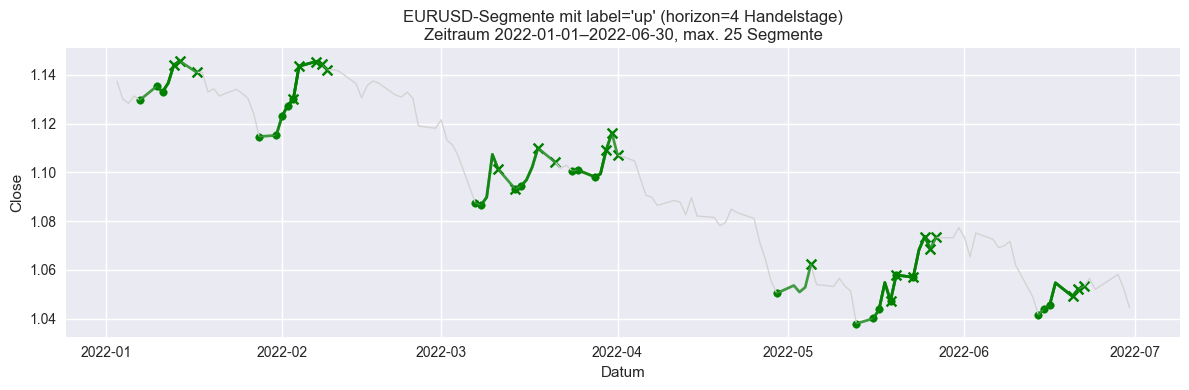

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Parameter – diese Werte kannst du im Notebook beliebig anpassen
# -------------------------------------------------------------------

horizon_steps = 4        # Muss zur aktuellen Label-Definition passen (shift(-4))
label_filter = "up"      # "up" oder "down" – welche Klasse visualisieren?
window_start = "2022-01-01"
window_end = "2022-06-30"
max_segments = 25        # Max. Anzahl Segmente, die übereinander geplottet werden

# df_labels: DataFrame mit EURUSD-Labels
# - typischerweise aus: data/processed/fx/eurusd_labels__<EXP_ID>.csv
# - Spalten: Date/date, Close, label, lookahead_return, ...
# -------------------------------------------------------------------

df = df_labels.copy()

# 1) Einheitliche Datums-Spalte herstellen (entweder "date" oder "Date")
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    date_col = "date"
elif "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    date_col = "Date"
else:
    raise KeyError("Weder 'date' noch 'Date' Spalte gefunden – bitte prüfen, wie das CSV eingelesen wurde.")

# Chronologisch sortieren und Index zurücksetzen, damit Index-Schritte = Handelstage sind
df = df.sort_values(date_col).reset_index(drop=True)

# 2) Starttage innerhalb des gewünschten Fensters wählen
mask_window = (df[date_col] >= window_start) & (df[date_col] <= window_end)
starts = df[mask_window & (df["label"] == label_filter)].copy()

# Anzahl Segmente begrenzen, damit der Plot lesbar bleibt
starts = starts.head(max_segments)

print(f"{len(starts)} Starttage mit label='{label_filter}' im Fenster {window_start}–{window_end} ausgewählt.")

# 3) Für die Visualisierung brauchen wir Kursdaten rund um das Zeitfenster,
#    damit die Segmente im Kontext sichtbar sind.
plot_start = pd.to_datetime(window_start)
plot_end = pd.to_datetime(window_end)

plot_mask = (df[date_col] >= plot_start) & (df[date_col] <= plot_end)
df_plot = df[plot_mask].copy()

# 4) Plot erstellen
fig, ax = plt.subplots(figsize=(12, 4))

# Gesamt-Zeitreihe im Plotfenster als dünne graue Linie (Referenz)
ax.plot(
    df_plot[date_col],
    df_plot["Close"],
    color="lightgray",
    linewidth=1,
    label="Close (gesamt im Fenster)",
)

# Farbwahl je nach Label-Klasse (nur für die Segmente)
segment_color = "green" if label_filter == "up" else "red"

# 5) Für jeden Starttag das Segment von t bis t + horizon_steps einzeichnen
for _, row in starts.iterrows():
    # Index-Position des Starttages im DataFrame (nach reset_index)
    start_pos = int(row.name)
    end_pos = start_pos + horizon_steps

    # Wenn nicht mehr genug Daten bis zum Horizont vorhanden sind, Segment überspringen
    if end_pos >= len(df):
        continue

    # Segment als fortlaufender Block von Index-Schritten (Handelstage)
    seg = df.iloc[start_pos : end_pos + 1].copy()

    # Pfad zeichnen
    ax.plot(
        seg[date_col],
        seg["Close"],
        color=segment_color,
        linewidth=2,
        alpha=0.7,
    )

    # Startpunkt (t) markieren – gelabelter Tag
    ax.scatter(
        seg[date_col].iloc[0],
        seg["Close"].iloc[0],
        color=segment_color,
        s=30,
        label=None,
    )

    # Horizonttag (t + horizon_steps) markieren
    ax.scatter(
        seg[date_col].iloc[-1],
        seg["Close"].iloc[-1],
        color=segment_color,
        s=50,
        marker="x",
        label=None,
    )

# 6) Achsenbeschriftung und Titel
ax.set_title(
    f"EURUSD-Segmente mit label='{label_filter}' "
    f"(horizon={horizon_steps} Handelstage)\n"
    f"Zeitraum {window_start}–{window_end}, max. {len(starts)} Segmente"
)
ax.set_xlabel("Datum")
ax.set_ylabel("Close")

plt.tight_layout()
plt.show()


## Pfad-Analyse der Up-/Down-Segmente (Index-Schritte)

Hier möchte ich mir für `up`- und `down`-Labels die **Pfadverläufe über die 4 Handelstage** anschauen, die auch im Labeling verwendet werden.

Wichtig:

- Im Label-Code (`label_eurusd`) wird der Horizont mit `shift(-horizon_days)` berechnet.
  Das bedeutet: *4 Index-Schritte voraus*, also 4 Handelstage (nicht 4 Kalendertage).
- In dieser Visualisierung nutze ich dieselbe Logik:
  - Starttag = Index-Position `i`
  - Horizont = Index-Position `i + horizon_steps` (z.B. 4)
- Für jeden gelabelten Starttag im gewählten Zeitfenster baue ich ein Segment von
  **Schritt 0..4** und plotte:
  - den absoluten Close-Verlauf
  - und die relative Veränderung zum Starttag.

Damit kann ich gut sehen, wie stark der Kurs **zwischen** Start- und Horizonttag schwankt und ob z.B. eine „maximale Gegenbewegung“ sinnvoll wäre.


15 Starttage mit label='up' im Fenster 2022-05-01–2022-07-30.
Beispielhafte Zeilen aus seg_df:
   segment_start_idx segment_start_date  step       date     close  rel_close
0               1918         2022-05-13     0 2022-05-13  1.037958   0.000000
1               1918         2022-05-13     1 2022-05-16  1.040063   0.002028
2               1918         2022-05-13     2 2022-05-17  1.043896   0.005721
3               1918         2022-05-13     3 2022-05-18  1.054786   0.016212
4               1918         2022-05-13     4 2022-05-19  1.047274   0.008975


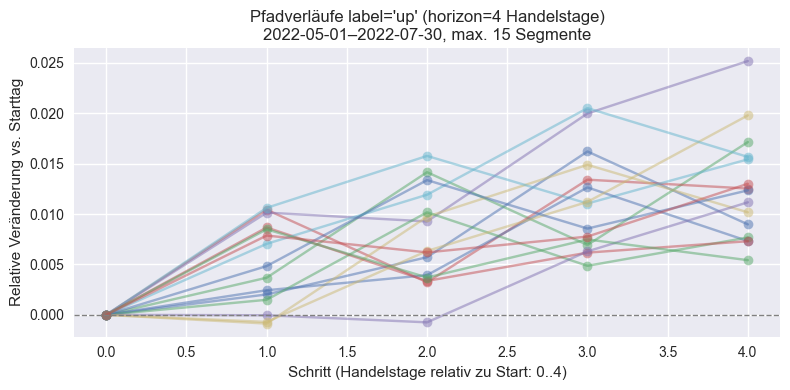

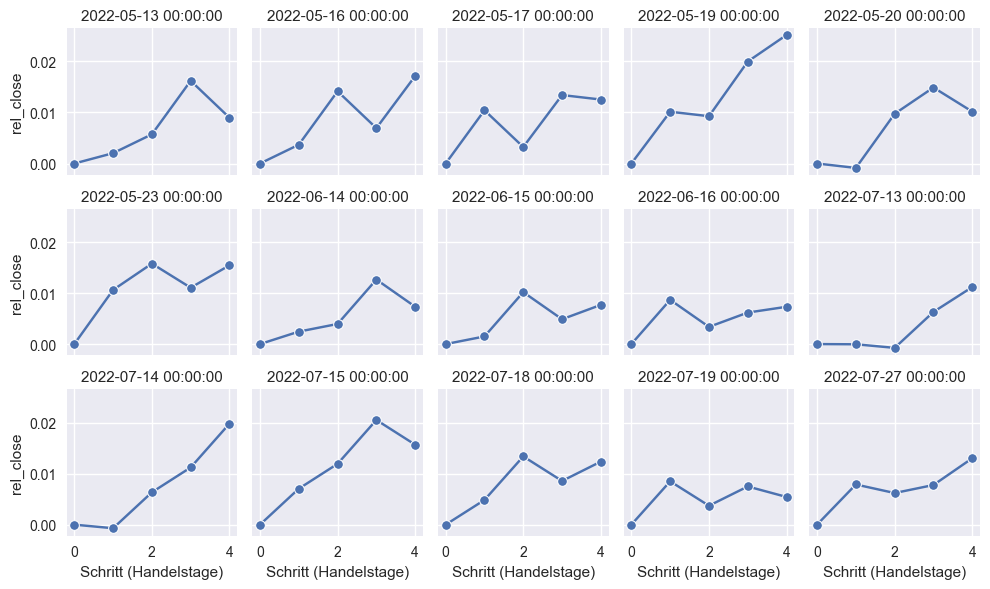

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------
# Parameter anpassen
# ----------------------------------------------------------
horizon_steps = 4               # muss zu label_eurusd(horizon_days) passen
label_filter = "up"             # "up" oder "down"
window_start = "2022-05-01"
window_end = "2022-07-30"
max_segments = 20               # max. Anzahl Segmente
# ----------------------------------------------------------

df = df_labels.copy()

# 1) Datums-Spalte vereinheitlichen und DataFrame chronologisch sortieren
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    date_col = "date"
elif "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    date_col = "Date"
else:
    raise KeyError("Weder 'date' noch 'Date' in df_labels gefunden.")

df = df.sort_values(date_col).reset_index(drop=True)  # RangeIndex: 0..N-1

# 2) Starttage im gewünschten Zeitfenster und mit gewünschtem Label wählen
mask_window = (df[date_col] >= window_start) & (df[date_col] <= window_end)
starts = (
    df[mask_window & (df["label"] == label_filter)]
    .sort_values(date_col)
    .head(max_segments)
)

print(f"{len(starts)} Starttage mit label='{label_filter}' im Fenster {window_start}–{window_end}.")

# ----------------------------------------------------------
# 3) Segmente als „langes“ DataFrame aufbauen:
#    jede Zeile = ein Tag in einem Segment
#    -> Schritt 0..horizon_steps, mit absolutem und relativem Close
# ----------------------------------------------------------
rows = []
for _, start_row in starts.iterrows():
    start_pos = int(start_row.name)             # Index-Position in df
    end_pos = start_pos + horizon_steps

    # Wenn nicht mehr genug Daten bis zum Horizont vorhanden sind, Segment überspringen
    if end_pos >= len(df):
        continue

    seg = df.iloc[start_pos : end_pos + 1].copy()  # inkl. Horizonttag
    start_close = seg["Close"].iloc[0]

    for step, (_, r) in enumerate(seg.iterrows()):
        rows.append(
            {
                "segment_start_idx": start_pos,           # Index des Starttages
                "segment_start_date": seg[date_col].iloc[0],
                "step": step,                              # 0..horizon_steps
                "date": r[date_col],
                "close": r["Close"],
                "rel_close": r["Close"] / start_close - 1.0,  # rel. zu Starttag
            }
        )

seg_df = pd.DataFrame(rows)
print("Beispielhafte Zeilen aus seg_df:")
print(seg_df.head())

# ----------------------------------------------------------
# 4) Plot: Alle Segmente übereinander (relative Veränderung)
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))

for seg_id, seg in seg_df.groupby("segment_start_idx"):
    ax.plot(
        seg["step"],
        seg["rel_close"],
        marker="o",
        alpha=0.5,
    )

ax.axhline(0.0, color="gray", linewidth=1, linestyle="--")
ax.set_xlabel("Schritt (Handelstage relativ zu Start: 0..4)")
ax.set_ylabel("Relative Veränderung vs. Starttag")
ax.set_title(
    f"Pfadverläufe label='{label_filter}' (horizon={horizon_steps} Handelstage)\n"
    f"{window_start}–{window_end}, max. {starts.shape[0]} Segmente"
)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 5) Optional: Small-Multiples – ein Panel pro Segment
# ----------------------------------------------------------
g = sns.FacetGrid(
    seg_df,
    col="segment_start_date",
    col_wrap=5,
    height=2.0,
    sharey=True,
)

g.map_dataframe(sns.lineplot, x="step", y="rel_close", marker="o")
g.set_axis_labels("Schritt (Handelstage)", "rel_close")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()


## Analyse: Wie gut trifft die aktuelle Label-Strategie große Moves?

Ziel dieser Analyse:

- Ich definiere zunächst **„große Moves“** rein über den 4‑Tage‑Return,
  z.B. `|lookahead_return| ≥ 0.5 %` (oder 1 %).
- Diese Tage sind meine „idealen Kandidaten“, die aus Trading-Sicht interessant wären.
- Danach prüfe ich:

  - **Wie viele** dieser großen Moves haben aktuell `signal = 1` (Recall auf Signal-Ebene)?
  - Wie gut treffen die Label-Klassen `up` und `down` diese großen Moves?
    - großer Up-Move → Label `up`?
    - großer Down-Move → Label `down`?

So sehe ich, ob meine Label-Definition eher zu viele große Moves als „neutral“ verliert
oder ob sie die interessanten Tage gut abdeckt.


In [7]:
import pandas as pd
import numpy as np

# ----------------------------------------------------------
# 1) Labels laden (Experiment wählen)
# ----------------------------------------------------------
EXP_ID = "v3_h4_thr0p3pct_relaxed"  # hier ggf. andere EXP_ID testen

labels_path = project_root / "data" / "processed" / "fx" / f"eurusd_labels__{EXP_ID}.csv"
df = pd.read_csv(labels_path)

# Datums-Spalte vereinheitlichen
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    date_col = "date"
elif "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    date_col = "Date"
else:
    raise KeyError("Weder 'date' noch 'Date' in Label-Datei gefunden.")

df = df.sort_values(date_col).reset_index(drop=True)

print(f"Geladene Labels aus {labels_path}, Form: {df.shape}")

# Nach df = df.sort_values(date_col).reset_index(drop=True)

# Falls 'signal' (0=neutral, 1=move) noch nicht existiert, aus dem Label ableiten
if "signal" not in df.columns:
    df["signal"] = (df["label"] != "neutral").astype(int)

# ----------------------------------------------------------
# 2) „Große Moves“ definieren (nur über lookahead_return)
# ----------------------------------------------------------
thr_ideal = 0.005  # 0.5 %; für 1 % -> 0.01 setzen

df["is_big_move"] = df["lookahead_return"].abs() >= thr_ideal
df["is_big_up"] = df["lookahead_return"] >= thr_ideal
df["is_big_down"] = df["lookahead_return"] <= -thr_ideal

big = df[df["is_big_move"]].copy()
print(f"Anzahl großer Moves (|lookahead_return| >= {thr_ideal:.3%}): {len(big)}")

# ----------------------------------------------------------
# 3) Coverage der aktuellen Labels auf diesen großen Moves
# ----------------------------------------------------------

# Anteil großer Moves, die überhaupt als signal=1 markiert wurden
coverage_signal = (big["signal"] == 1).mean()

# Recall für Up: großer Up-Move und Label==up
if big["is_big_up"].sum() > 0:
    coverage_up = ((big["label"] == "up") & big["is_big_up"]).sum() / big["is_big_up"].sum()
else:
    coverage_up = np.nan

# Recall für Down: großer Down-Move und Label==down
if big["is_big_down"].sum() > 0:
    coverage_down = ((big["label"] == "down") & big["is_big_down"]).sum() / big["is_big_down"].sum()
else:
    coverage_down = np.nan

print("\nCoverage der aktuellen Label-Strategie auf großen Moves:")
print(f"- Anteil großer Moves mit signal=1:      {coverage_signal:6.3%}")
print(f"- Recall großer Up-Moves   (label='up'): {coverage_up:6.3%}")
print(f"- Recall großer Down-Moves (label='down'):{coverage_down:6.3%}")






Geladene Labels aus /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/data/processed/fx/eurusd_labels__v3_h4_thr0p3pct_relaxed.csv, Form: (2824, 8)
Anzahl großer Moves (|lookahead_return| >= 0.500%): 1567

Coverage der aktuellen Label-Strategie auf großen Moves:
- Anteil großer Moves mit signal=1:      100.000%
- Recall großer Up-Moves   (label='up'): 100.000%
- Recall großer Down-Moves (label='down'):100.000%


## Analyse: Wie stark laufen große Moves zwischendurch gegen uns?

Um eine „tolerante“ Pfadregel zu definieren, möchte ich wissen:

- Bei großen Up-Moves (`lookahead_return ≥ Schwelle`):
  - Wie weit fällt der Kurs **zwischen** Start und Horizont maximal unter den Startkurs?
- Bei großen Down-Moves:
  - Wie weit steigt der Kurs zwischendurch maximal über den Startkurs?

Vorgehen:

- Für jeden großen Up-/Down-Move laufe ich über die 4 Handelstage
  (`horizon_steps = 4`) und berechne:
  - Up: `min(C_t..C_{t+4}) / C_t - 1`  → maximale negative Gegenbewegung (sollte ≤ 0 sein)
  - Down: `max(C_t..C_{t+4}) / C_t - 1` → maximale positive Gegenbewegung (sollte ≥ 0 sein)
- Danach schaue ich mir z.B. die 10/50/90‑Prozent‑Quantile an.
  So kann ich z.B. sagen:
  > „90 % der großen Up-Moves fallen zwischendurch nie mehr als −0.4 % unter den Start.“

Diese Information kann ich verwenden, um eine sinnvolle `max_adverse_move_pct`
für eine „tolerante“ Label-Variante zu wählen.


In [8]:
import numpy as np

# Wir nutzen dieselbe df wie oben (df mit Labels), inkl. sortiertem Index
horizon_steps = 4  # muss zur Label-Definition passen

close = df["Close"].to_numpy()

max_adverse_up = []    # maximale negative Gegenbewegung bei großen Up-Moves
max_adverse_down = []  # maximale positive Gegenbewegung bei großen Down-Moves

for i, row in df[df["is_big_move"]].iterrows():
    # Sicherstellen, dass noch genug Daten bis zum Horizont vorhanden sind
    if i + horizon_steps >= len(df):
        continue

    seg = close[i : i + horizon_steps + 1]  # Close-Werte von t bis t+4
    start = seg[0]

    if row["is_big_up"]:
        # Für Up: interessiert uns das Minimum im Segment (maximaler Rücksetzer)
        min_seg = seg.min()
        adverse = (min_seg - start) / start  # typischerweise <= 0
        max_adverse_up.append(adverse)

    if row["is_big_down"]:
        # Für Down: interessiert uns das Maximum im Segment (maximaler Rücksetzer nach oben)
        max_seg = seg.max()
        adverse = (max_seg - start) / start  # typischerweise >= 0
        max_adverse_down.append(adverse)

max_adverse_up = pd.Series(max_adverse_up, name="max_adverse_up")
max_adverse_down = pd.Series(max_adverse_down, name="max_adverse_down")

print("Quantile der maximalen Gegenbewegung für große Up-Moves:")
print(max_adverse_up.quantile([0.1, 0.5, 0.9]).apply(lambda x: f"{x:.3%}"))

print("\nQuantile der maximalen Gegenbewegung für große Down-Moves:")
print(max_adverse_down.quantile([0.1, 0.5, 0.9]).apply(lambda x: f"{x:.3%}"))


Quantile der maximalen Gegenbewegung für große Up-Moves:
0.1    -0.339%
0.5     0.000%
0.9     0.000%
Name: max_adverse_up, dtype: object

Quantile der maximalen Gegenbewegung für große Down-Moves:
0.1    0.000%
0.5    0.000%
0.9    0.344%
Name: max_adverse_down, dtype: object
